<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#2.1-Conjecture-proof" data-toc-modified-id="2.1-Conjecture-proof-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>2.1 Conjecture proof</a></span></li><li><span><a href="#2.1-Sensitivity-to-misclassification-error-in-the-locality-partitions" data-toc-modified-id="2.1-Sensitivity-to-misclassification-error-in-the-locality-partitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2.1 Sensitivity to misclassification error in the locality partitions</a></span></li><li><span><a href="#2.2-Sensitivity-of-quotas-to-temporal-splits" data-toc-modified-id="2.2-Sensitivity-of-quotas-to-temporal-splits-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2.2 Sensitivity of quotas to temporal splits</a></span></li><li><span><a href="#2.3-Bad-assignments" data-toc-modified-id="2.3-Bad-assignments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>2.3 Bad assignments</a></span></li><li><span><a href="#By-type-of-refugees" data-toc-modified-id="By-type-of-refugees-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>By type of refugees</a></span></li></ul></div>

# Allocating Refugee to Municipalities

This notebook implements and simulates the refugee allocation mechanism described in the paper. The assignment functions and utilities for measuring and evaluating the assignment quality are contained in the module ``assignment_function.py``, which we import below, together with other packages required for initializing the simulation.

This notebook is divided in two parts. In the first part we replicate and illustrate the allocation example provided in the paper. 

In the second part we assess the sensitivity of the assignment algorithm to misclassification errors from estimations (*useful reference: The Science paper reports 26% misclassification error in their estimates*). In this section we
simulate random flows of refugees and allocate them according to the allocation mechanism proposed in the paper. We evaluate the sensitivity of the assignments to misclassification errors in terms of both fairness and efficiency with respect to a naive sequential assignment, and identify the parameters that most strongly affect these relationships.

**To be done**
* Sensitivity to quotas. How to restart the mechanism? (no error)
* Heterogeneity in municipalities. Some municipalities are just better for most refugees
* Quotas: Some real numbers? Swedish migration authority should be able to give us some data on refugee outcomes (employment). Make it realistic
    * Simulate quotas with legacy
* BIG TABLES: Over e.g. NA proportion, key measures (Efficiency, envy>0, envy>X) (error, NA+AA, NA, AA).
    * Deadline: 15th March

In [135]:
# Import packages
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
import datetime
import assignment_function as af

import seaborn as sns     
import matplotlib.pyplot as plt                             # Data visualization
sns.set_style("ticks", {'axes.grid': True})
import matplotlib.cm as cm
from IPython.display import display


# Animation
#from matplotlib import animation, rc
#from IPython.display import HTML

# Reload library (temporary - for editing the functions)
import importlib

import time
def f_writetime(time):
    hours = np.int8(np.floor(time/3600))
    minutes = np.int8(np.floor((time - hours*3600)/60))
    seconds = np.floor(time - hours*3600 - minutes*60)
    
    return str(hours) + " hour(s), " + str(minutes) + " minute(s), and " + str(seconds) + " seconds"
    

# 1. Example

In this section we replicate the allocation example provided in the paper. We refer to $N$ as the number of refugees in the refugee flows and to $M$ as the number of municipalities in the economy. The assignment function takes as **inputs**:

1. A **mandatory** *acceptability matrix* $N\times M$ representing a refugee flow. In this matrix each column corresponds to a municipality, and each row to a refugee. Elements of the matrix indicate whether or not (1/0) the refugee is considered acceptable by the municipality.

2. An optional array of municipality quotas. The order of the municipalities listed must be the same as that of the *acceptability matrix*. If no quotas are specified, each municipality is assigned a quota equal to the number of refugees in the flow $N$.

3. An optional initial priority ordering $\pi$. This option allows for the algorithm to take dynamically into consideration earlier refugee flows when allocating the new flow of refugees. 

4. An optional rejection ordering $\sigma$. This option allows for the algorithm to take dynamically into consideration earlier refugee flows when allocating the new flow of refugees. 

5. An optional *envy matrix* $M\times M$ representing the state of envy across municipalities before allocating the first refugee in the flow. This option allows for the algorithm to take dynamically into consideration earlier refugee flows when allocating the new flow of refugees. 

Element $i,j$ of an *envy matrix* represents  the amount of envy municipality $i$ holds for municipality $j$. Negative numbers represent municipalities preferring their own allocation to that of another municipality. Zeros indicate indifference. Positive numbers indicate that a municipality prefers the allocation assigned o another municipality. The theoretical result of the paper guarantee that the maximum element of this matrix is at most equal to 1 (envy by at most one refugee).

The function returns an object with **properties**:

1. An *assignment matrix* $N\times M$ ( ``matrix_assignment``) representing the assignment of the refugee flow. Each row has only one positive element equal to one. Element $i,j$ being equal to one means that the algorithm assigned refugee $i$ to municipality $j$.

2. An updated array of municipality quotas following the assignment (``end_quotas``)

3. Rank and envy legacies for dynamic allocation of a second flow of refugees
    1. Priority ranking $\pi(N)$ (``pi``)
    2. Rejection ranking $\sigma(N)$ (``sigma``)
    3. Envy matrix at $N$ (``envy_final``)

We start by creating the acceptability matrix used as an example in the paper

In [7]:
# Inputs
refugee_types =np.array([1,1,2,2,1,1,3,4,1,2])
accept_municipality = np.array([
                            [0,1,1,0],
                            [0,1,1,1],
                            [0,1,0,1],
                        ])

# Rework inputs
# Goal: matrix NxM with binary indicators or acceptable or not
refugee_types = np.transpose(refugee_types) - 1
accept_municipality = np.transpose(accept_municipality)

matrix_acceptability = accept_municipality[refugee_types]

print(matrix_acceptability)

[[0 0 0]
 [0 0 0]
 [1 1 1]
 [1 1 1]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [0 1 1]
 [0 0 0]
 [1 1 1]]


We can now call the assignment function, and print the assignment output. We also print the legacy indicators $\pi(N)$, $\sigma(N)$, and the envy matrix at $N$

In [45]:
matrix_acceptability = np.array([[1,0,1]])
matrix_acceptability

array([[1, 0, 1]])

In [86]:
importlib.reload(af)

# Call the function
assignment = af.assign(matrix_acceptability,vector_quotas=np.array([10,10,10])) #,vector_quotas=np.array([2,8,8]))

# Print assignment
print('Assignment matrix:')
print(assignment.assignment)
print('\n' 'pi(N) =', assignment.pi, '; sigma(N) =', assignment.sigma)
print('\n' 'Final envy matrix:')
print(assignment.envy_final)

Assignment matrix:
[[1 0 0]]

pi(N) = [3 1 2] ; sigma(N) = [1 2 3]

Final envy matrix:
[[ 0 -1 -1]
 [-1  0  0]
 [ 1  0  0]]


We can compare this allocation to what we would have obtained by allocating asylum seekers naively -- by sequentially assigning asylum seekers to municipalities as they arrive independently by their type until quotas are filled. In this particular example, at the end of the assignent of asylum seekers we see that municipality $m_{2}$ envies municipality $m_{1}$ by three asylum seekers. Such an uninformed allocation, by chance, creates a substantial disparity between municipality $m_{1}$, which is pretty satisfied by its allocation, and the others.

In [9]:
assignment_random = af.assign_seq(matrix_acceptability)

print('Final envy matrix:')
print(assignment_random.get_envy(real_acceptance=matrix_acceptability))

Final envy matrix:
[[ 0 -5 -3]
 [ 3  0  0]
 [ 1  0  0]]


# 2. Dynamic properties of the algorithm

## 2.1 Conjecture proof
Proving that we never observe envy>1, either in acceptable or in non-acceptable refugees

Random refugee flow characteristic. Random refugee. Assign them. Then calculate their envy at all intervals, store them in large matrix recording refugee number and envy for each municipality. Matrix length is then 20*n_sim*n_ref. Memory issue? Max 10000 sim x 1000 refs 

In [2]:
# Set parameters
np.random.seed(0)

n_simulations = 5000
n_refugees = 1000
n_municipalities = 20

In [3]:
# Start simulation
start_time = time.time()
results = {}
results["envy_demanded"] = []
results["envy_nondemanded"] = []
results["n_refugee"] = []


simint = round(n_simulations/10)
for sim in range(n_simulations):
    if sim%simint==0:
        print("Simulation", sim, "of", n_simulations, 
              ". Elapsed time:", f_writetime(time.time() - start_time))
    # Generate random refugee flow
    p1 = np.random.uniform()
    p0 = np.random.uniform(0, 1-p1)
    which = np.random.randint(2)
    p_nond= which*p1 + (1-which)*p0
    p_over= which*p0 + (1-which)*p1
    autocorrelation = np.random.uniform()
    demand_matrix = af.simulate_matrix(n_refugees, n_municipalities, 
                                           p_nond = p_nond, 
                                           p_over = p_over, 
                                           autocorrelation = autocorrelation
                                          )
    # assign refugees
    assignment = af.assign(demand_matrix)
    # record envy at each refugee
    # foreach refugee
    for k in range(n_refugees):
        for ref_type in ["demanded", "nondemanded"]:
            envy = assignment.get_envy(refugee=k, ref_type=ref_type)
            np.fill_diagonal(envy, -n_refugees)
            envy_max = np.amax(envy, axis=1)
            results["envy_{}".format(ref_type)] += envy_max.tolist()
        results["n_refugee"] += [k] * n_municipalities

import pickle
for var in ['envy_demanded', 'envy_nondemanded', 'n_refugee']:
    with open('data/sim_conj_{}'.format(var), 'wb') as fp:
        pickle.dump(results[var], fp)

results = {}
# Elapsed time
elapsed_time = time.time() - start_time
print('Total running time: ', f_writetime(elapsed_time))
# Save running time
f = open('timers/misclassification.txt','a')
f.write(
    'Date: ' + str(datetime.date.today()) + '\n' +
    'Parameters: ' + '\n' + 
    '  - # simulations: ' + str(n_simulations) + '\n'
    '  - # refugees   : ' + str(n_refugees) + '\n'
    '  - # localities : ' + str(n_municipalities) + '\n'
    'Total running time: ' + f_writetime(elapsed_time) + '\n\n'
)
f.close()

Simulation 0 of 5000 . Elapsed time: 0 hour(s), 0 minute(s), and 0.0 seconds
Simulation 500 of 5000 . Elapsed time: 0 hour(s), 6 minute(s), and 20.0 seconds
Simulation 1000 of 5000 . Elapsed time: 0 hour(s), 12 minute(s), and 43.0 seconds
Simulation 1500 of 5000 . Elapsed time: 0 hour(s), 19 minute(s), and 1.0 seconds
Simulation 2000 of 5000 . Elapsed time: 0 hour(s), 25 minute(s), and 19.0 seconds
Simulation 2500 of 5000 . Elapsed time: 0 hour(s), 31 minute(s), and 37.0 seconds
Simulation 3000 of 5000 . Elapsed time: 0 hour(s), 37 minute(s), and 55.0 seconds
Simulation 3500 of 5000 . Elapsed time: 0 hour(s), 44 minute(s), and 13.0 seconds
Simulation 4000 of 5000 . Elapsed time: 0 hour(s), 50 minute(s), and 31.0 seconds
Simulation 4500 of 5000 . Elapsed time: 0 hour(s), 56 minute(s), and 49.0 seconds
Total running time:  1 hour(s), 3 minute(s), and 19.0 seconds


In [4]:
# Import data
sim_conj = pd.DataFrame().astype('int16')
for var in ['envy_demanded', 'envy_nondemanded', 'n_refugee']:
    sim_conj[var] = pd.read_pickle("./data/sim_conj_{}".format(var))

# Generate tables
sim_conj['group_ref']= pd.cut(sim_conj['n_refugee'], [0,100,500,1000], right=False, labels=False)

summary = {}
for var in ['demanded', 'nondemanded']:
    summary['{}'.format(var)] = sim_conj.groupby("group_ref")['envy_{}'.format(var)].describe(percentiles=[0.1, 0.5, 0.9])
    summary['{}'.format(var)] = summary['{}'.format(var)].drop(['count','mean', 'std', 'min'], axis=1)
    summary['{}'.format(var)] = summary['{}'.format(var)].astype('int16')
    summary['{}_byref'.format(var)] = sim_conj.groupby("n_refugee")['envy_{}'.format(var)].describe(percentiles=[0.1, 0.5, 0.9])
    summary['{}_byref'.format(var)] = summary['{}_byref'.format(var)].drop(['count','mean', 'std'], axis=1)
    summary['{}_byref'.format(var)] = summary['{}_byref'.format(var)].astype('int16')


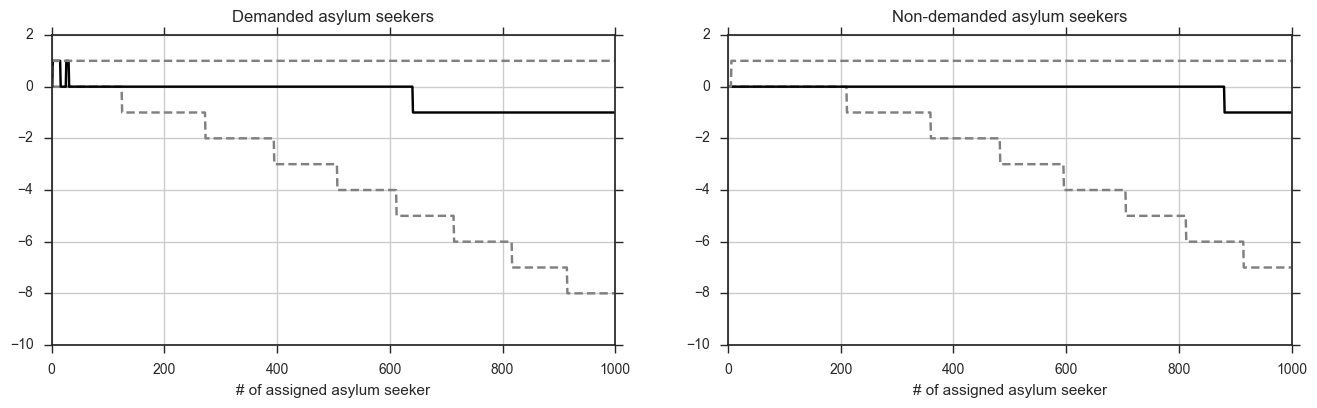

In [5]:
# Export table
table =  summary['demanded'].merge(summary['nondemanded'], left_index=True, right_index=True)
table = np.hstack(([['1-100'],['101-500'],['501-1000']],table.values.tolist()))
np.savetxt(
    "tabs/conjecture/simres.txt", 
    table, delimiter=' & ', fmt='%s', newline=' \\\\\n'
)

# Export figure
plt.close('all')
fig, axarr = plt.subplots(1, 2, sharey=False,figsize=(16,4))


axarr[0].set_title('Demanded asylum seekers', y=1.02)
axarr[0].set_ylim(-10,2)
axarr[0].plot(summary['demanded_byref']['10%'], color='gray', dashes=[6, 3], label='max')
axarr[0].plot(summary['demanded_byref']['50%'], color='black', label='Median')
axarr[0].plot(summary['demanded_byref']['90%'], color='gray', dashes=[6, 3], label='min')
axarr[0].set_xlabel('# of assigned asylum seeker')

axarr[1].set_title('Non-demanded asylum seekers', y=1.02)
axarr[1].set_ylim(-10,2)
axarr[1].plot(summary['nondemanded_byref']['10%'], color='gray', dashes=[6, 3], label='max')
axarr[1].plot(summary['nondemanded_byref']['50%'], color='black', label='Median')
axarr[1].plot(summary['nondemanded_byref']['90%'], color='gray', dashes=[6, 3], label='min')
axarr[1].set_xlabel('# of assigned asylum seeker')

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#          fancybox=True, shadow=True, ncol=3, handlelength=4)
plt.savefig('figs/conjecture/both.pdf', bbox_inches = 'tight')

plt.show()

## 2.1 Sensitivity to misclassification error in the locality partitions

In this section we focus on highlighting the dynamic properties of the algorithm, allowing for imperfect inputs to the model. More specifically, we analyze how measures of **fairness** and **efficiency** develop for the baseline AEM dynamic algorithm, and compare assignments of the same refugees given a sequential assignment mechanism and the AEM given that the estimation matrix has been estimated ith 10%, 20%, 30% and 40% misclassification error.

Our dynamic measures of **fairness** is the proportion of municipalites envying at least another municipality in the sample by 1 and by a fourth of the average assigned refugees per municipality. Note that if the the average number of assigned refugees per municipalities is $>4$, then the AEM algorithm guarantees that our second measure is equal to 0 at each allocation $k$.

Our dynamic measure of **efficiency** is the proportion of *demanded* refugees that are assigned to a municipality that considers them non-demanded. Reallocating (ex-post) such a refugee to a demanding municipality would be a Pareto-improvement. Again, with perfect information the AEM algorithm ensures that this measure is equal to 0 for each $k$.

In order to assess the gains in fairness and efficiency due to the algorithm, we simulate random refugee flows calibrated to match the US and the Swedish situation, scramble the real demand matrix with an increasing amount of misclassification error, and compare the resulting assignment with that of a naive sequential algorithm. As we argue for in the paper, the algorithm works best when the proportion of refugees that exhibit synergies across localitites (i.e., that integrate in some localities but not others) is highest. When calibrating the asylum seeker flows we put ourselves in a worst-case scenario situation by minimizing the number of 'synergic' refugees (type $D$). The proportion of refugees of type $\overline{D}$  in the refugee flow is given by the lowest amount of refugees finding employment within 3 months (US data) and 3 years (Swedish data) across localities. The proportion of refugees of type $\underline{D}$ is given by the highest amount of refugee not finding employment across localities in the same time period.

The cell below sets the simulation parameters.

In [2]:
np.random.seed(0)

# set general parameters
n_simulations = 1000
n_refugees = 1000
n_municipalities = {}
n_municipalities['swe'] = 21
n_municipalities['us'] = 50

# set country-specific parameters (AA, NA, autocorrelation)
refflow = {}
refflow['us'] =  [0.34, 0.39, 0.5] ## AA: Science paper
refflow['swe'] = [0.28, 0.45, 0.5] ## AA: 3-years employment rate of 2013 refugee wave

envy_limit = 5 #int(np.round((n_refugees/n_municipalities)*0.25)) 

errorslist = [0, 10, 25, 40]
sim_types = ['err_{0}'.format(err) for err in errorslist]
sim_types.append('sequential')

The next cell runs the simulation proper, and saves (pickles) the results in the files `data/simerror_swe` and `data/simerror_us` for later use  

In [3]:
start_time = time.time()
# Simulation
importlib.reload(af)
output = np.zeros((n_refugees, len(sim_types)*3))

# Dictionaries initialization
assignments = {}
mis_dem = {}

for country in ['swe','us']:
    simint = round(n_simulations/10)
    for sim in np.arange(n_simulations):
        if sim%simint==0:
            print("Country:", country, "; Simulation", sim, "of", n_simulations, 
                  ". Elapsed time:", f_writetime(time.time() - start_time))

        # simulate demand/refugee flow
        demand_matrix = af.simulate_matrix(n_refugees, n_municipalities[country], 
                                           p_nond = refflow[country][0], 
                                           p_over = refflow[country][1], 
                                           autocorrelation = refflow[country][2]
                                          )

        n_demanded_refugees = np.cumsum(np.amax(demand_matrix, axis=1))

        assignments['sequential'] = af.assign_seq(demand_matrix)
        # Initialize misallocated count
        mis_dem['sequential'] = 0
        for error in errorslist:
            assignments['err_{0}'.format(error)] = af.assign(af.add_error(demand_matrix, error))
            # Initialize misallocated count
            mis_dem['err_{0}'.format(error)] = 0

        # foreach refugee
        for k in np.arange(n_refugees):
            for val, atype in enumerate(sim_types):
                # update misallocated count
                if (np.sum(demand_matrix[k])>0) and (np.sum(assignments[atype].assignment[k][:]*demand_matrix[k][:])==0):
                    mis_dem[atype] += 1
                # calculate measures
                max_envy = np.amax(assignments[atype].get_envy(refugee=k,real_acceptance=demand_matrix), axis=1)
                envy0 = np.mean((max_envy>0))
                envy1 = np.mean((max_envy>=envy_limit))
                if n_demanded_refugees[k]>0:
                    effic = mis_dem[atype]/n_demanded_refugees[k]
                else:
                    effic = 0

                # Update averages
                output[k,val*3 + 0] = (output[k,val*3 + 0]*(sim) + envy0)/(sim+1)
                output[k,val*3 + 1] = (output[k,val*3 + 1]*(sim) + envy1)/(sim+1)
                output[k,val*3 + 2] = (output[k,val*3 + 2]*(sim) + effic)/(sim+1)

    nameslist = []
    for atype in sim_types:
        nameslist.append('envy0_'+atype)
        nameslist.append('envy1_'+atype)
        nameslist.append('effic_'+atype)
    if country == 'swe':
        simerror_swe = pd.DataFrame(output, columns=nameslist)
        simerror_swe.to_pickle("data/simerror_swe")
    if country == 'us':
        simerror_us = pd.DataFrame(output, columns=nameslist)
        simerror_us.to_pickle("data/simerror_us")

elapsed_time = time.time() - start_time
print('Total running time: ', f_writetime(elapsed_time))
# Save running time
f = open('timers/misclassification.txt','a')
f.write(
    'Date: ' + str(datetime.date.today()) + '\n' +
    'Parameters: ' + '\n' + 
    '  - # simulations: ' + str(n_simulations) + '\n'
    '  - # refugees   : ' + str(n_refugees) + '\n'
    '  - # localities : ' + str(n_municipalities) + '\n'
    'Total running time: ' + f_writetime(elapsed_time) + '\n\n'
)
f.close()

Country: swe ; Simulation 0 of 1000 . Elapsed time: 0 hour(s), 0 minute(s), and 0.0 seconds
Country: swe ; Simulation 100 of 1000 . Elapsed time: 0 hour(s), 4 minute(s), and 0.0 seconds
Country: swe ; Simulation 200 of 1000 . Elapsed time: 0 hour(s), 8 minute(s), and 0.0 seconds
Country: swe ; Simulation 300 of 1000 . Elapsed time: 0 hour(s), 12 minute(s), and 1.0 seconds
Country: swe ; Simulation 400 of 1000 . Elapsed time: 0 hour(s), 16 minute(s), and 0.0 seconds
Country: swe ; Simulation 500 of 1000 . Elapsed time: 0 hour(s), 19 minute(s), and 59.0 seconds
Country: swe ; Simulation 600 of 1000 . Elapsed time: 0 hour(s), 23 minute(s), and 57.0 seconds
Country: swe ; Simulation 700 of 1000 . Elapsed time: 0 hour(s), 27 minute(s), and 55.0 seconds
Country: swe ; Simulation 800 of 1000 . Elapsed time: 0 hour(s), 31 minute(s), and 53.0 seconds
Country: swe ; Simulation 900 of 1000 . Elapsed time: 0 hour(s), 35 minute(s), and 51.0 seconds
Country: us ; Simulation 0 of 1000 . Elapsed time:

In [4]:
# Clear matplotlib memory
plt.close('all')

simerror = {}
# Load data
simerror['swe'] = pd.read_pickle("data/simerror_swe")
simerror['us'] = pd.read_pickle("data/simerror_us")

tempdic = {}
df = pd.DataFrame(index=['envy0', 'envy1', 'effic'])
for country in ['swe','us']:
    for err in ['25']:
        tempdic['{0}_{1}'.format(country,err)] = []
        tempdic['{0}_{1}'.format(country,err)].append(
            -(simerror['{0}'.format(country)]['envy0_err_{}'.format(err)][999] -
            simerror['{0}'.format(country)]['envy0_sequential'][999])/
            simerror['{0}'.format(country)]['envy0_sequential'][999]
        )
        tempdic['{0}_{1}'.format(country,err)].append(
            -(simerror['{0}'.format(country)]['envy1_err_{}'.format(err)][999]-
            simerror['{0}'.format(country)]['envy1_sequential'][999])/
            simerror['{0}'.format(country)]['envy1_sequential'][999]
        )
        tempdic['{0}_{1}'.format(country,err)].append(
            -(simerror['{0}'.format(country)]['effic_err_{}'.format(err)][999]-
            simerror['{0}'.format(country)]['effic_sequential'][999])/
            simerror['{0}'.format(country)]['effic_sequential'][999]
        )

df = pd.DataFrame.from_dict(tempdic).set_index([['envy0', 'envy1', 'effic']])
print('Final simulation values, decrease wrt sequential assignment:')
display(df)

Final simulation values, decrease wrt sequential assignment:


,swe_25,us_25
envy0,0.228661,0.066697
envy1,0.330913,0.160448
effic,0.499298,0.498023


The next cell loads the simulation results, and creates the graphs used in the paper

C:\Users\Alessandro\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


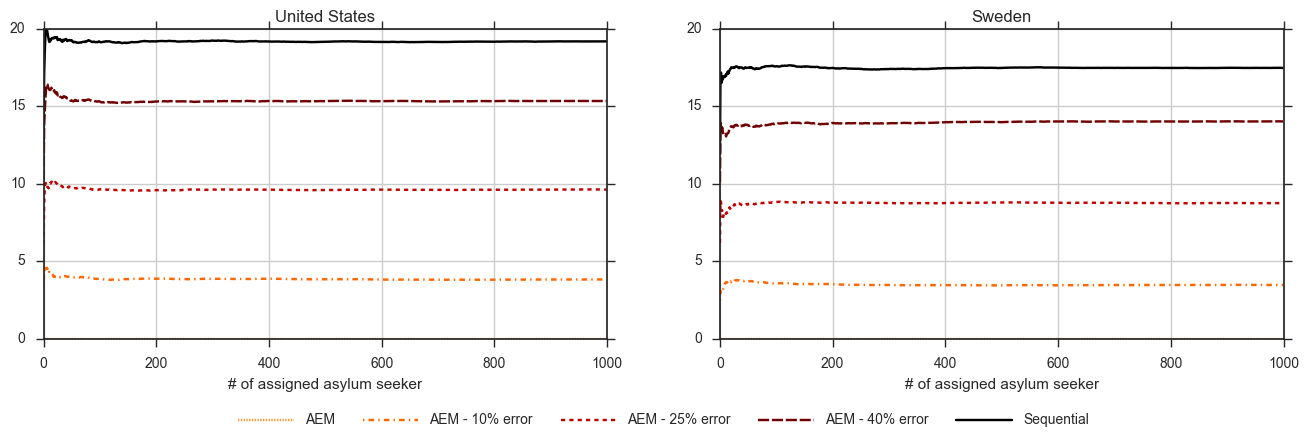

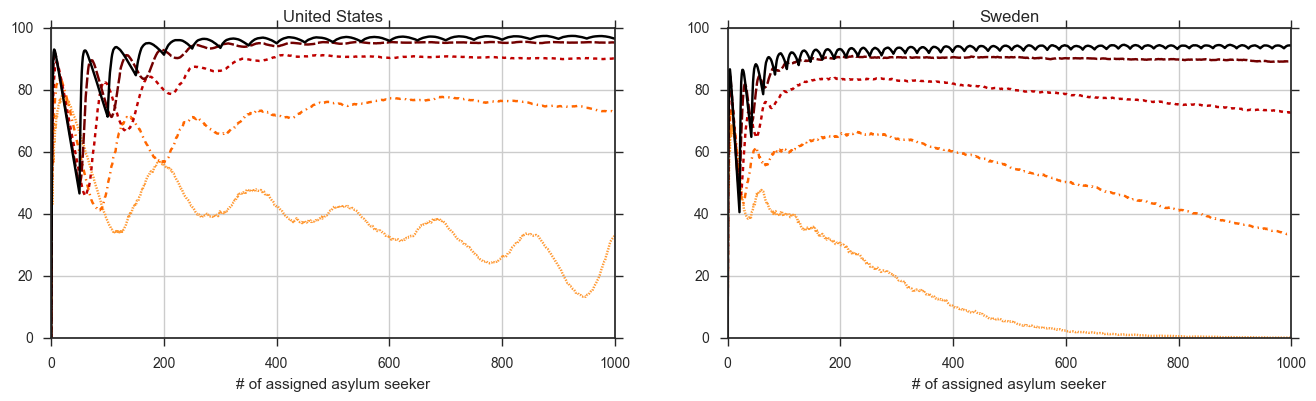

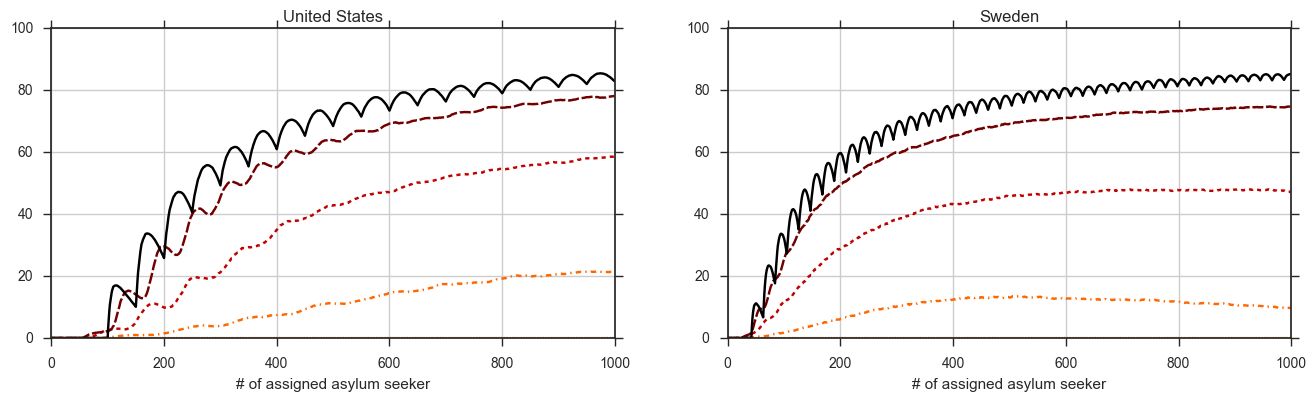

In [172]:
# Clear matplotlib memory
plt.close('all')

simerror = {}
# Load data
simerror['swe'] = pd.read_pickle("data/simerror_swe")
simerror['us'] = pd.read_pickle("data/simerror_us")


# Small figures
for measure in ['envy0', 'envy1', 'effic']:
    for country in ['us', 'swe']:
        plt.close('all')
        plt.figure(figsize=(8,5))
        if measure == 'effic':
            plt.ylim(0, 20)
        else:
            plt.ylim(0, 100)
        plt.plot(simerror[country]['{0}_err_0'.format(measure)]*100, color=cm.gist_heat(0.8), dashes=[1, 1], label='AEM')
        plt.plot(simerror[country]['{0}_err_10'.format(measure)]*100, color=cm.gist_heat(0.7), dashes=[1, 3, 4, 3], label='AEM - 10% error')
        plt.plot(simerror[country]['{0}_err_25'.format(measure)]*100, color=cm.gist_heat(0.5), dashes=[3, 3], label='AEM - 25% error')
        plt.plot(simerror[country]['{0}_err_40'.format(measure)]*100, color=cm.gist_heat(0.3), dashes=[8, 2], label='AEM - 40% error')
        plt.plot(simerror[country]['{0}_sequential'.format(measure)]*100, color=cm.gist_heat(0), label='Sequential')
        plt.xlabel('# of assigned asylum seeker')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                  fancybox=True, shadow=True, ncol=3, handlelength=4)
        plt.savefig('figs/misclassification/single_{0}_{1}_new.pdf'.format(measure,country), bbox_inches = 'tight')
        

# double figures

for measure in ['effic', 'envy0', 'envy1']:
    plt.close('all')
    fig, axarr = plt.subplots(1, 2, sharey=False,figsize=(16,4))
    
    col = 0        
    for country in ['us', 'swe']:

        if measure == 'effic':
            axarr[col].set_ylim(0, 20)
            axarr[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.2),
                        fancybox=True, shadow=True, ncol=6, handlelength=4)
        else:
            axarr[col].set_ylim(0, 100)
        if country == 'us':
            axarr[col].set_title('United States')
        if country == 'swe':
            axarr[col].set_title('Sweden')
        axarr[col].plot(simerror[country]['{0}_err_0'.format(measure)]*100, color=cm.gist_heat(0.8), dashes=[1, 1],label='AEM')
        axarr[col].plot(simerror[country]['{0}_err_10'.format(measure)]*100, color=cm.gist_heat(0.7), dashes=[1, 3, 4, 3], label='AEM - 10% error')
        axarr[col].plot(simerror[country]['{0}_err_25'.format(measure)]*100, color=cm.gist_heat(0.5), dashes=[3, 3], label='AEM - 25% error')
        axarr[col].plot(simerror[country]['{0}_err_40'.format(measure)]*100, color=cm.gist_heat(0.3), dashes=[8, 2], label='AEM - 40% error')
        axarr[col].plot(simerror[country]['{0}_sequential'.format(measure)]*100, color=cm.gist_heat(0), label='Sequential')
        axarr[col].set_xlabel('# of assigned asylum seeker')

        col += 1
        
    plt.savefig('figs/misclassification/double_{0}_new.pdf'.format(measure), bbox_inches = 'tight')
    plt.show()


## 2.2 Sensitivity of quotas to temporal splits

Description TBD

In [164]:
np.random.seed(0)
# Set parameters
vector_quotas = np.array([180,616,277,213,816,365,697,388,323,894,620,870,2793,347,6904,1031,645,915,532,414,3760])
# rearrange quotas to be divisible by 12
vector_quotas = np.int32(np.round(vector_quotas/12)*12)

n_simulations = 1000
n_municipalities = vector_quotas.size
splits = [1, 2, 4, 12]

envy1_limit = 5

errors = [0, 24]

n_refugees = np.int(np.sum(vector_quotas))
print('# asylum seekers: ', n_refugees)

# asylum seekers:  23568


In [168]:
real_matrix = af.simulate_matrix(n_refugees, n_municipalities, 
                                              p_over=0.28,
                                              p_nond=0.45,
                                              autocorrelation=0.5
                                             )
seq = af.assign_seq(real_matrix, vector_quotas=vector_quotas)
af.calc_envy(real_matrix, assignment = seq.assignment)

array([[    0,   -88,     0,     8,   -74,   -30,   -70,   -44,     6,
          -58,   -60,   -96,  -330,    38, -1032,  -126,   -20,  -112,
          -36,   -48,  -428],
       [   92,     0,    72,    96,   -26,    54,    20,    62,    94,
          -12,    46,     0,  -252,   114, -1014,   -86,    64,   -26,
           74,    36,  -284],
       [   14,   -60,     0,     6,   -58,   -36,   -62,   -32,    14,
          -72,   -48,   -90,  -308,    38, -1072,  -130,   -32,  -108,
          -22,   -46,  -382],
       [   16,   -66,   -14,     0,  -100,   -42,   -30,   -36,    -6,
          -86,   -44,  -106,  -300,    32, -1032,  -178,   -24,  -116,
          -30,   -56,  -404],
       [   80,    -4,    60,    82,     0,    42,    36,    26,    88,
           -8,    30,   -30,  -252,   114, -1056,   -80,    46,   -44,
           54,    22,  -322],
       [   36,   -42,    12,    18,   -54,     0,   -36,   -16,    36,
          -62,   -20,   -94,  -290,    58, -1032,  -136,     6,  -108

In [156]:
# simulate
importlib.reload(af)
start_time = time.time()
#simquotas = pd.DataFrame(columns=['wave','splits', 
#                                    'method', 'fair0', 'fair1' , 'effic'])
data = []
simint = round(n_simulations/10)

for sim in range(n_simulations):

    if simint!=0:
        if sim%simint==0:
            print("Simulation", sim, "of", n_simulations, ". Elapsed time:", f_writetime(time.time() - start_time))
    # Simulate matrix
    real_matrix = af.simulate_matrix(n_refugees, n_municipalities, 
                                              p_over=0.28,
                                              p_nond=0.45,
                                              autocorrelation=0.5
                                             )
    for err in errors:
        #demand_matrix = af.scramble_matrix(real_matrix, false_negatives=err, false_positives=err)
        demand_matrix = af.add_error(real_matrix, err=err)
        
        for split in splits:
            # calculate new_quotas
            split_quotas =  np.int32(vector_quotas/split)
            n_ref_start = 0
            n_ref_end = np.int(n_refugees/split)

            envy_init = np.zeros((n_municipalities, n_municipalities))
            assignments = {}
            assignments['aem'] = np.array([], dtype=np.int8).reshape(0,n_municipalities)
            assignments['aem_legacy'] = np.array([], dtype=np.int8).reshape(0,n_municipalities)
            assignments['seq'] = np.array([], dtype=np.int8).reshape(0,n_municipalities)
            for lap in range(split):
                demand_submatrix = demand_matrix[n_ref_start:n_ref_end, :]
                # assign according to three criteria
                aem = af.assign(demand_submatrix , vector_quotas=split_quotas)
                aem_legacy = af.assign(demand_submatrix, vector_quotas=split_quotas, envy_init = envy_init)
                seq = af.assign_seq(demand_submatrix, vector_quotas=split_quotas)
                # append until final assignment reached
                assignments['aem'] = np.append(assignments['aem'], aem.assignment, axis=0)
                assignments['aem_legacy'] = np.append(assignments['aem_legacy'], aem_legacy.assignment, axis=0)
                assignments['seq'] = np.append(assignments['seq'], seq.assignment, axis=0)
                # Update start and end measures
                envy_init = np.int32(af.calc_envy(demand_matrix[:n_ref_end,:], assignment = assignments['aem_legacy']))
                n_ref_start += np.int(n_refugees/split)
                n_ref_end += np.int(n_refugees/split)
            # Calculate measures at ref N
            max_envy = {}
            for method in ['aem', 'aem_legacy', 'seq']:
                max_envy[method] = np.amax(af.calc_envy(real_matrix, assignment = assignments[method]), axis=1)
                fair0 = np.mean(max_envy[method]>0)
                fair1 = np.mean(max_envy[method]>=envy1_limit)
                effic = np.sum(
                    (np.sum(real_matrix, axis=1)>0)*(1-(np.sum(real_matrix*assignments[method], axis=1)>0)) ) / np.sum(
                    np.sum(real_matrix, axis=1)>0)
                data.append([sim, err, split, method, fair0, fair1, effic])
    # start new simulation
        
simquotas = pd.DataFrame(data, columns=['wave','error','splits', 
                                        'method', 'fair0', 'fair1' , 'effic'])
simquotas.to_pickle("data/simquotas")
elapsed_time = time.time() - start_time
print('Total running time: ', f_writetime(elapsed_time))
# Save running time
f = open('timers/quotas.txt','a')
f.write(
    'Date: ' + str(datetime.date.today()) + '\n' +
    'Parameters: ' + '\n' + 
    '  - # simulations: ' + str(n_simulations) + '\n'
    '  - # refugees   : ' + str(n_refugees) + '\n'
    '  - # localities : ' + str(n_municipalities) + '\n'
    'Total running time: ' + f_writetime(elapsed_time) + '\n\n'
)
f.close()

Simulation 0 of 1000 . Elapsed time: 0 hour(s), 0 minute(s), and 0.0 seconds
Simulation 100 of 1000 . Elapsed time: 0 hour(s), 34 minute(s), and 40.0 seconds
Simulation 200 of 1000 . Elapsed time: 1 hour(s), 9 minute(s), and 6.0 seconds
Simulation 300 of 1000 . Elapsed time: 1 hour(s), 43 minute(s), and 17.0 seconds
Simulation 400 of 1000 . Elapsed time: 2 hour(s), 18 minute(s), and 7.0 seconds
Simulation 500 of 1000 . Elapsed time: 2 hour(s), 52 minute(s), and 19.0 seconds
Simulation 600 of 1000 . Elapsed time: 3 hour(s), 27 minute(s), and 21.0 seconds
Simulation 700 of 1000 . Elapsed time: 4 hour(s), 2 minute(s), and 32.0 seconds
Simulation 800 of 1000 . Elapsed time: 4 hour(s), 37 minute(s), and 34.0 seconds
Simulation 900 of 1000 . Elapsed time: 5 hour(s), 12 minute(s), and 37.0 seconds
Total running time:  5 hour(s), 47 minute(s), and 49.0 seconds


The next cell loads the simulation data and creates the plots

In [157]:
# Load and label data
simquotas = pd.read_pickle("data/simquotas")
simquotas['label'] = np.select([simquotas['method']=='aem', simquotas['method']=='aem_legacy', simquotas['method']=='seq']
                             , ['AEM','AEM with envy legacy', 'Sequential']
                             )
# Export table
for method, label in zip(['seq', 'aem', 'aem_legacy'], ['Sequential', 'AEM', 'AEM with envy legacy']):
    for error in [0, 24]:
        select = simquotas[np.logical_and(simquotas['method']==method, simquotas['error']==error)]
        baseline = select[select['splits']==1].set_index('wave')
        listtoexport = []
        for n_stat, stat in enumerate([np.mean, np.std, np.median]):
            row = ['']
            for var, scale in zip(['effic', 'fair0'], [100,21]):
                value = stat((baseline[var]*scale).values)
                # Put value into list according to order
                if n_stat == 1: 
                    row += ['({:0.2f})'.format(value)]
                elif n_stat == 2:
                    row += ['[{:0.2f}]'.format(value)]
                else:
                    row += ['{:0.2f}'.format(value)]
                for split in [2,4,12]:
                    value = stat((select[select['splits']==split].set_index('wave')[var]*scale)) # - baseline[var]*scale).values
                    # Put value into list according to order
                    if n_stat == 1:
                        row += ['({:0.2f})'.format(value)]
                    elif n_stat == 2:
                        row += ['[{:0.2f}]'.format(value)]
                    else:
                        row += ['{:0.2f}'.format(value)]
            listtoexport.append(row)
        listtoexport[0][0]= label
        # Export to latex
        np.savetxt(
            "tabs/quotas/quotas_{0}_{1}.txt".format(method, error), 
            listtoexport, delimiter=' & ', fmt='%s', newline=' \\\\\n'
        )

C:\Users\Alessandro\Anaconda3\lib\site-packages\seaborn\categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
C:\Users\Alessandro\Anaconda3\lib\site-packages\seaborn\categorical.py:932: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


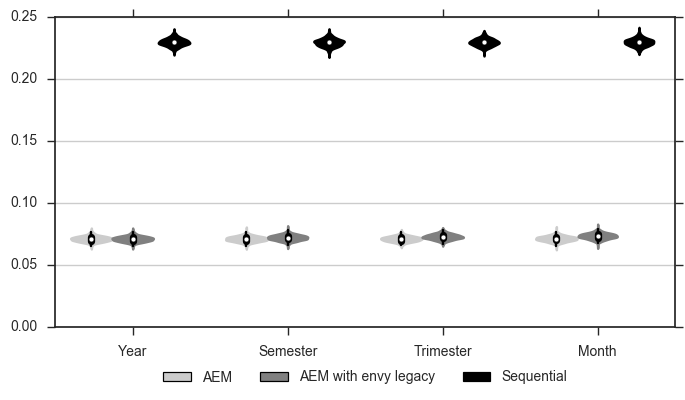

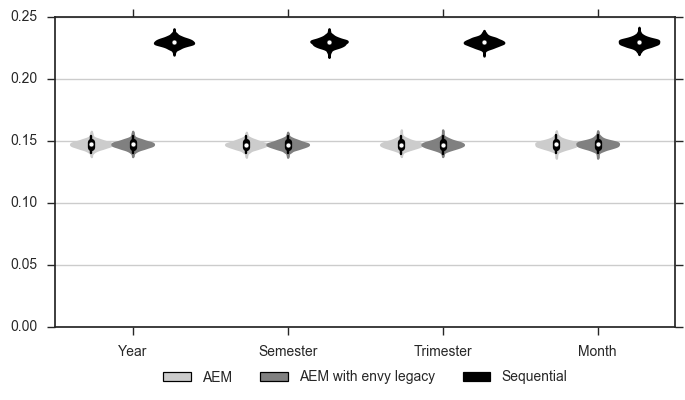

In [158]:
# Export figure
plt.close('all')
fig, ax = plt.subplots(figsize=(8,4))

for err in errors:
    simwork = simquotas.loc[simquotas['error']==err] # SELECT ONLY IF ERROR==`ERR'
    #groupby_wave = simwork.groupby(['wave']) 
    #simwork['fair0_diff'] = simwork.groupby(['wave'])['fair0'].mean()

    plt.close('all')
    fig, ax = plt.subplots(figsize=(8,4))
    ax = sns.violinplot(x="splits", y="effic", hue="label", 
                        data=simwork, palette=['0.8', 'gray', 'black'], ax=ax)
    
    ax.set(xticklabels=['Year', 'Semester', 'Trimester', 'Month'],
           xlabel="",
           ylabel = "",
           ylim = (0, 0.25)
          )
    #ax.set_title("Proportion of misallocated acceptable refugees", y=1.02)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                      fancybox=True, shadow=True, ncol=3)

    plt.savefig('figs/quotas/single_effic_{0}_new.pdf'.format(err), bbox_inches = 'tight')
    plt.show()
    
    
    plt.close('all')
    fig, ax = plt.subplots(figsize=(8,4))
    ax = sns.violinplot(x="splits", y="fair1", hue="label", 
                        data=simwork, palette=['0.8', 'gray', 'black'], ax=ax)
    ax.set(xticklabels=['Year', 'Semester', 'Trimester', 'Month'],
           xlabel="",
           ylabel = ""
          )
    #ax.set_title("Proportion of misallocated acceptable refugees", y=1.02)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                      fancybox=True, shadow=True, ncol=3)

    plt.savefig('figs/quotas/single_fair1_{0}_new.pdf'.format(err), bbox_inches = 'tight')


    
    plt.close('all')
    fig, ax = plt.subplots(figsize=(8,4))
    ax = sns.violinplot(x="splits", y="fair0", hue="label", 
                        data=simwork, palette=['0.8', 'gray', 'black'], ax=ax)
    ax.set(xticklabels=['Year', 'Semester', 'Trimester', 'Month'],
           xlabel="",
           ylabel = ""
          )
    #ax.set_title("Proportion of misallocated acceptable refugees", y=1.02)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                      fancybox=True, shadow=True, ncol=3, handlelength=4)

    plt.savefig('figs/quotas/single_fair0_{0}_new.pdf'.format(err), bbox_inches = 'tight')

## 2.3 Bad assignments


In [159]:
# set general parameters
n_simulations = 1000
n_refugees = 1000
n_municipalities = 21

envy1_limit = 5

# types of simulation
sim_types = ['random', 'sequential', 'err_50']

# demand matrix parameters
refflow = {}
refflow['us'] =  [0.34, 0.39, 0.5] ## AA: Science paper
refflow['swe'] = [0.28, 0.45, 0.5] ## AA: 3-years employment rate of 2013 refugee wave

In [160]:
start_time = time.time()
# Simulation
importlib.reload(af)
output = np.zeros((n_refugees, len(sim_types)*3))

# Dictionaries initialization
assignments = {}
mis_dem = {}

simint = round(n_simulations/10)
for sim in np.arange(n_simulations):
    if sim%simint==0:
        print("Simulation", sim, "of", n_simulations, ". Elapsed time:", f_writetime(time.time() - start_time))
    # simulate demand/refugee flow
    demand_matrix = af.simulate_matrix(n_refugees, n_municipalities, 
                                       p_nond = refflow['swe'][0], 
                                       p_over = refflow['swe'][1], 
                                       autocorrelation = refflow['swe'][2]
                                      )
    
    n_demanded_refugees = np.cumsum(np.amax(demand_matrix, axis=1))
    
    for atype in sim_types:
        # Assignment
        if atype=='random':
            assignments[atype] = af.assign_random(demand_matrix)
        if atype=='sequential':
            assignments[atype] = af.assign_seq(demand_matrix)
        if atype=='err_50':
            assignments[atype] = af.assign(af.add_error(demand_matrix, 50))
        # Initialize misallocated count
        mis_dem[atype] = 0
    # foreach refugee
    for k in np.arange(n_refugees):
        for val, atype in enumerate(sim_types):
            # update misallocated count
            if (np.sum(demand_matrix[k])>0) and (np.sum(assignments[atype].assignment[k][:]*demand_matrix[k][:])==0):
                mis_dem[atype] += 1
            # calculate measures
            max_envy = np.amax(assignments[atype].get_envy(refugee=k,real_acceptance=demand_matrix), axis=1)
            envy0 = np.mean((max_envy>0))
            envy1 = np.mean((max_envy>=envy1_limit))
            if n_demanded_refugees[k]>0:
                effic = mis_dem[atype]/n_demanded_refugees[k]
            else:
                effic = 0
            
            # Update averages
            output[k,val*3 + 0] = (output[k,val*3 + 0]*(sim) + envy0)/(sim+1)
            output[k,val*3 + 1] = (output[k,val*3 + 1]*(sim) + envy1)/(sim+1)
            output[k,val*3 + 2] = (output[k,val*3 + 2]*(sim) + effic)/(sim+1)

nameslist = []
for atype in sim_types:
    nameslist.append('envy0_'+atype)
    nameslist.append('envy1_'+atype)
    nameslist.append('effic_'+atype)
bad_assignments = pd.DataFrame(output, columns=nameslist)
bad_assignments.to_pickle("data/bad_assignments")

elapsed_time = time.time() - start_time
print('Total running time: ', f_writetime(elapsed_time))
# Save running time
f = open('timers/bad_assignments.txt','a')
f.write(
    'Date: ' + str(datetime.date.today()) + '\n' +
    'Parameters: ' + '\n' + 
    '  - # simulations: ' + str(n_simulations) + '\n'
    '  - # refugees   : ' + str(n_refugees) + '\n'
    '  - # localities : ' + str(n_municipalities) + '\n'
    'Total running time: ' + f_writetime(elapsed_time) + '\n\n'
)
f.close()

Simulation 0 of 1000 . Elapsed time: 0 hour(s), 0 minute(s), and 0.0 seconds
Simulation 100 of 1000 . Elapsed time: 0 hour(s), 2 minute(s), and 7.0 seconds
Simulation 200 of 1000 . Elapsed time: 0 hour(s), 4 minute(s), and 15.0 seconds
Simulation 300 of 1000 . Elapsed time: 0 hour(s), 6 minute(s), and 26.0 seconds
Simulation 400 of 1000 . Elapsed time: 0 hour(s), 8 minute(s), and 33.0 seconds
Simulation 500 of 1000 . Elapsed time: 0 hour(s), 10 minute(s), and 41.0 seconds
Simulation 600 of 1000 . Elapsed time: 0 hour(s), 12 minute(s), and 49.0 seconds
Simulation 700 of 1000 . Elapsed time: 0 hour(s), 14 minute(s), and 57.0 seconds
Simulation 800 of 1000 . Elapsed time: 0 hour(s), 17 minute(s), and 4.0 seconds
Simulation 900 of 1000 . Elapsed time: 0 hour(s), 19 minute(s), and 12.0 seconds
Total running time:  0 hour(s), 21 minute(s), and 20.0 seconds


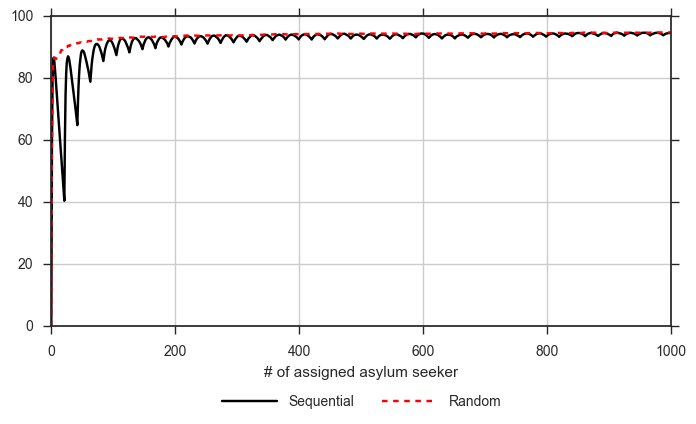

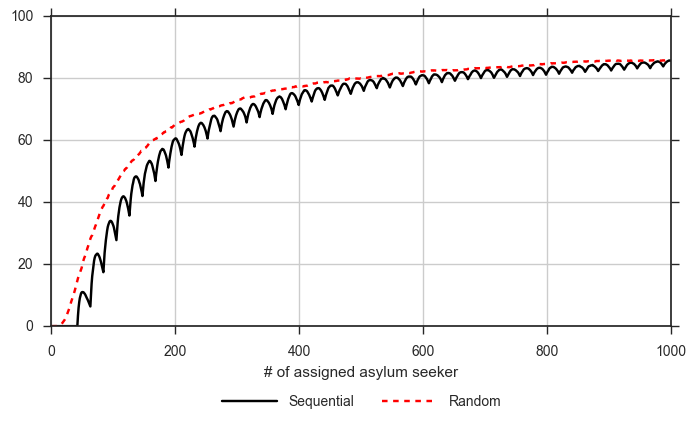

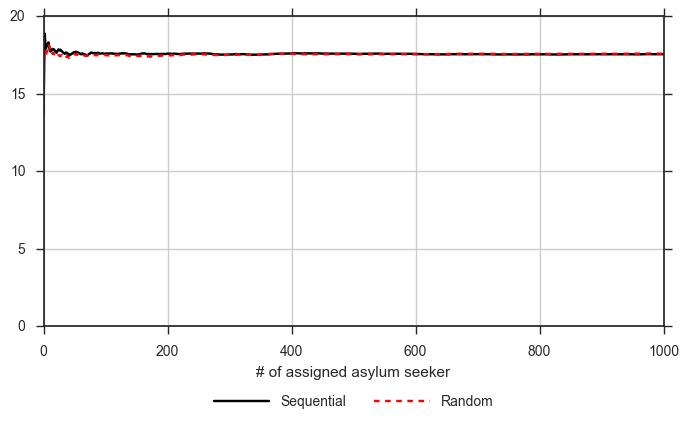

In [173]:
# Load data
bad_assignments = pd.read_pickle("data/bad_assignments")

# Small figures
for measure in ['envy0', 'envy1', 'effic']:
    plt.close('all')
    plt.figure(figsize=(8,4))
    if measure == 'effic':
        plt.ylim(0, 20)
    else:
        plt.ylim(0, 100)
    
    plt.plot(bad_assignments['{0}_sequential'.format(measure)]*100, color=cm.gist_heat(0), label='Sequential')
    #plt.plot(bad_assignments['{0}_err_50'.format(measure)], color='blue', dashes=[1, 1], label='AEM, 50% error')
    plt.plot(bad_assignments['{0}_random'.format(measure)]*100, color='red', dashes=[4, 4],  label='Random')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
              fancybox=True, shadow=True, ncol=3, handlelength=4)
    plt.xlabel('# of assigned asylum seeker')
    plt.ylabel=("Proportion (0-1)")
    plt.savefig('figs/bad_assignments/single_{0}.pdf'.format(measure), bbox_inches = 'tight')
    plt.show()

# Big appendix tables
## By type of refugees

Iterating over values of $\overline{D}$ and $\underline{D}$. 10 pct point-spaced interval.

In [162]:
np.random.seed(0)
# Set parameters for the simulation
# set general parameters
n_simulations = 1000
n_refugees = 1000
n_municipalities = 21

# types of simulation
errors = [0, 10, 25, 40, 50]
autocorrelation = 0.5

#Measure for envy
envy_limit = 1

In [163]:
# Start simulation
start_time = time.time()
for overbar_D in np.arange(0,100 +1,10, dtype=np.int16):
    final_output = []
    for underbar_D in np.arange(0,100-overbar_D +1,10, dtype=np.int16):
        if overbar_D+underbar_D + overbar_D*underbar_D!=100: # Removes uninteresting cases
            # initialize vector of zeroes 1x(lenght of errors * 2) row_output
            row_output = np.zeros(np.size(errors)*2)
            seq_output = np.zeros(np.size(errors)*2)
            for sim in np.arange(n_simulations): 
                # Simulate true demand matrix
                demand_matrix = af.simulate_matrix(n_refugees, n_municipalities, 
                                       p_nond = underbar_D/100, 
                                       p_over = overbar_D/100, 
                                       autocorrelation = autocorrelation
                                      )

                # Get sequential assignment outcomes
                seq = af.assign_seq(demand_matrix)
                # Get envy_seq and eff_seq
                envy_seq = np.mean(np.amax(seq.get_envy(real_acceptance=demand_matrix), axis=1)>envy_limit)
                n_demanded = np.sum(np.amax(demand_matrix, axis=1))
                if n_demanded == 0:
                    eff_seq = 0
                else:
                    demand_indicator = np.max(demand_matrix, axis=1)
                    demand_indicator = np.tile(demand_indicator,(n_municipalities,1)).T
                    eff_seq = np.sum(demand_indicator*seq.assignment*(np.ones(np.shape(demand_matrix)) - demand_matrix))/n_demanded

                for err_counter, err in enumerate(errors):
                    # scramble matrix
                    # Calculate assignment of scrambled matrix
                    ass = af.assign(af.add_error(demand_matrix, err))

                    # get final outcome of envy, save it
                    envy = np.mean(np.amax(ass.get_envy(real_acceptance=demand_matrix), axis=1)>=envy_limit)

                    row_output[err_counter] = (row_output[err_counter]*(sim) + envy)/(sim+1)
                    seq_output[err_counter] = (seq_output[err_counter]*(sim) + envy_seq)/(sim+1)

                    # get final outcome of eff, save it
                    if n_demanded == 0:
                        eff = 0
                    else:                
                        demand_indicator = np.max(demand_matrix, axis=1)
                        demand_indicator = np.tile(demand_indicator,(n_municipalities,1)).T
                        eff = np.sum(demand_indicator*ass.assignment*(np.ones(np.shape(demand_matrix)) - demand_matrix))/n_demanded


                    row_output[np.size(errors) + err_counter] = (row_output[np.size(errors) + err_counter]*(sim) + eff)/(sim+1)
                    seq_output[np.size(errors) + err_counter] = (seq_output[np.size(errors) + err_counter]*(sim) + eff_seq)/(sim+1)

            #seq_output_den = np.copy(seq_output)
            with np.errstate(divide='ignore',invalid='ignore'):
                row_output_final = 100*(seq_output - row_output)/seq_output
            row_output_final = row_output_final.tolist()
            row_output_final.insert(0, underbar_D)
            # append row_output/seq_output to final_output
            final_output.append(row_output_final)
    # Save tex file
    np.savetxt(
        "tabs/big_appendix/errtable_overD{0}.txt".format(overbar_D), 
        final_output, delimiter=' & ', fmt='%4.2f', newline=' \\\\\n'
    )

elapsed_time = time.time() - start_time
print('Total running time: ', f_writetime(elapsed_time))
# Save running time
f = open('timers/big_appendix_sim.txt','a')
f.write(
    'Date: ' + str(datetime.date.today()) + '\n' +
    'Parameters: ' + '\n' + 
    '  - # simulations: ' + str(n_simulations) + '\n'
    '  - # refugees   : ' + str(n_refugees) + '\n'
    '  - # localities : ' + str(n_municipalities) + '\n'
    'Total running time: ' + f_writetime(elapsed_time) + '\n\n'
)
f.close()

Total running time:  4 hour(s), 43 minute(s), and 1.0 seconds


In [ ]:
x = np.arange(0, 100+1, 10)
y = np.arange(0, 100+1, 10)
xx, yy = np.meshgrid(x, y)
z = xx+yy + xx*yy

#df= pd.DataFrame([xx,yy,z])
#df
print(z)

In [ ]:
demand_matrix = af.simulate_matrix(n_refugees, n_municipalities, 
                                   p_nond = 0.2, 
                                   p_over = 0.2, 
                                   autocorrelation = autocorrelation
                                  )
#seq = af.assign_seq(demand_matrix)
n_demanded = np.sum(np.amax(demand_matrix, axis=1))
ass = af.assign(demand_matrix)
demand_indicator = np.max(demand_matrix, axis=1)
demand_indicator = np.tile(demand_indicator,(n_municipalities,1)).T
print(demand_indicator)
eff = np.sum(ass.assignment*(np.ones(np.shape(demand_matrix)) - demand_matrix))/n_demanded
#np.sum(seq.assignment*(np.ones(np.shape(demand_matrix)) - demand_matrix))
# For saving tex file
# numpy.savetxt("mydata.csv", array, delimiter=' & ', fmt='%4.2e', newline=' \\\\\n')
print(demand_matrix)
#print(ass.assignment)
#print(ass.assignment*(np.ones(np.shape(demand_matrix)) - demand_matrix))
#print(n_demanded,eff)

In [ ]:
np.size(errors)